# Data Preprocessing

## Mount Drive 
This is just where we load the data in colabs, this step may not be necessary depending on who is running it and what IDE they use





In [2]:
from google.colab import drive
drive.mount('/content/drive')

# You may have a different directory you want to change to...
import os
os.chdir('/content/drive/My Drive/CA4015/sleep_classify')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load a sample of data

Next we show an example of how to load the raw data and the preprocessed 'cropped' data. You can use either data, we would recommend the processed data as it's cleaner: 

-- In cases where the battery on the Apple Watch failed before the sleep opportunity ended, the data was cropped to include only those time points for which valid data existed.

The preprocessed/cropped data was taken from ```preprocessing_runner.py``` as recommended from the authors of the data collection experiment [here](https://github.com/ojwalch/sleep_classifiers/tree/f8010da19efbb52924f8723f37854c33eafacc4c).

The processed data can be found in `./outputs/cropped/` folder. 
- We recommend to use this folder as the feature vector or 'X' data and the files in `./data/labels/` as the target vector or 'y' data.

- You can/should perform some further feature engineering on the 'X' data.



In [3]:
import numpy as np

x_clean = np.loadtxt('./outputs/cropped/46343_cleaned_motion.out')
print(x_clean.shape)

x_raw = np.loadtxt('./data/motion/46343_acceleration.txt')
print(x_raw.shape)

(850024, 4)
(982000, 4)


## Plot the sample data

In the raw data set we can see activity on left and right, but it looks like the watch must have died in between

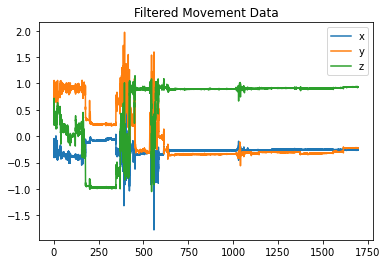

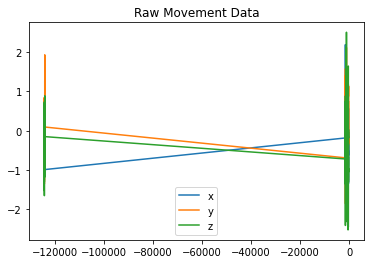

In [4]:
import matplotlib.pyplot as plt

sampfrom = 0
sampto = 85000 # Pick any value

plt.figure()
plt.plot(x_clean[sampfrom:sampto,0],x_clean[sampfrom:sampto,1], label='x')
plt.plot(x_clean[sampfrom:sampto,0],x_clean[sampfrom:sampto,2], label='y')
plt.plot(x_clean[sampfrom:sampto,0],x_clean[sampfrom:sampto,3], label='z')
plt.legend()
plt.title('Filtered Movement Data')
plt.show()

plt.figure()
plt.plot(x_raw[sampfrom:sampto,0],x_raw[sampfrom:sampto,1], label='x')
plt.plot(x_raw[sampfrom:sampto,0],x_raw[sampfrom:sampto,2], label='y')
plt.plot(x_raw[sampfrom:sampto,0],x_raw[sampfrom:sampto,3], label='z')
plt.legend()
plt.title('Raw Movement Data')
plt.show()

## Load a sample of Labels

The labels correspond to the following sleep states:


(undefined = -1, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)


Non-REM sleep is divided into progressively deeper stages of sleep: stage N1, stage N2, and stage N3.


As the authors never took note of what the -1 label referred to, we decided it made sense to remove these labels later for our analysis


In [5]:
# Load the labels for one subject
labels = np.loadtxt('./data/labels/46343_labeled_sleep.txt')
print(labels.shape)
np.unique(labels[:,1])

(567, 2)


array([-1.,  0.,  1.,  2.,  3.,  5.])

In [6]:
# Show me a sample of the labels
print(labels[520:530,:])

[[1.560e+04 2.000e+00]
 [1.563e+04 2.000e+00]
 [1.566e+04 2.000e+00]
 [1.569e+04 0.000e+00]
 [1.572e+04 0.000e+00]
 [1.575e+04 1.000e+00]
 [1.578e+04 1.000e+00]
 [1.581e+04 1.000e+00]
 [1.584e+04 0.000e+00]
 [1.587e+04 1.000e+00]]


The labels are given as:

[time since PSG start, sleep state]


---

## Tip:

You will have to segment your 'X' data to match the intervals of your 'y' data. See cell below:

In [7]:
print("First 10 label times (sec): ", labels[:10,0])
print("Index of X data where time less than or equal to 30: ", np.max(np.nonzero(x_clean[:,0] <= 30)))

First 10 label times (sec):  [  0.  30.  60.  90. 120. 150. 180. 210. 240. 270.]
Index of X data where time less than or equal to 30:  1503


The labels are segmented into 30 second sections for this subject. The 'X' data is not.

Look at `x_clean`, the first 1503 datapoints cover the sleep period from 0-30 seconds.

You will need to segment the data in some way to suit your approach.

---
---

# Data Processing

## Processing the data so we can use tsfresh to extract the time series features

Our first step was to get the full set of patient IDs which would be needed throughout the data processing

In [8]:
# Get a set of patient ids
FULL_SET = []

import os

for filename in os.listdir("./outputs/cropped/"):
  patient_id = filename.split("_")[0]
  if patient_id not in FULL_SET: 
        FULL_SET.append(patient_id)

print(FULL_SET)

['8692923', '46343', '1360686', '9618981', '844359', '6220552', '8000685', '781756', '1818471', '759667', '8173033', '4314139', '3997827', '8530312', '4426783', '2598705', '5132496', '7749105', '5797046', '1449548', '2638030', '9961348', '5383425', '4018081', '5498603', '8686948', '1066528', '8258170', '1455390', '9106476', '3509524']


We then needed to decide what features would be needed, we knew that we needed the motion data and the heart rate data but that the stepcounts wouldn't be useful here. Therefore our feature set was motion and heartrate.

In [9]:
# choose what features we will use
feature_set = {"motion" : True, "hr" : True, "counts" : False}

We wanted to take a look at how much datapoints there were for each patient to get an idea of what we would be dealing with. We saw here that there were 850,024 for patient ID 46343

In [10]:
import numpy as np

# we have 850,024 motion readings for this patient
motion_clean = np.loadtxt('./outputs/cropped/46343_cleaned_motion.out')
print(motion_clean.shape)
print(motion_clean[:10,:])

(850024, 4)
[[ 7.21000e-04 -2.34650e-01  9.05975e-01  3.62747e-01]
 [ 1.71620e-02 -2.31232e-01  8.93265e-01  3.71613e-01]
 [ 3.71830e-02 -2.27814e-01  9.15848e-01  3.69049e-01]
 [ 5.71080e-02 -2.40524e-01  9.19159e-01  3.52890e-01]
 [ 7.69290e-02 -2.40448e-01  8.89175e-01  3.50143e-01]
 [ 9.72060e-02 -2.30652e-01  8.98056e-01  3.54538e-01]
 [ 1.16890e-01 -2.44370e-01  8.88184e-01  3.49152e-01]
 [ 1.36826e-01 -2.45895e-01  8.91678e-01  3.55942e-01]
 [ 1.71897e-01 -2.46414e-01  9.04938e-01  3.55866e-01]
 [ 1.76799e-01 -2.49878e-01  8.99094e-01  3.62213e-01]]


There were 3,301 heartrate measurements for this same patient

In [11]:
# we have 3,301 HR readings for the same patient
hr_clean = np.loadtxt('./outputs/cropped/46343_cleaned_hr.out')
print(hr_clean.shape)

(3301, 2)


However, we only have 567 sleep status labels for this same patient. Clearly there would be signficant work involved in matching the motion and heartrate data to these sleep status labels

In [12]:
# Load the labels for one subject
labels = np.loadtxt('./data/labels/46343_labeled_sleep.txt')
print(labels.shape)

(567, 2)


In [13]:
# Show me a sample of the labels
print(labels[520:530,:])

[[1.560e+04 2.000e+00]
 [1.563e+04 2.000e+00]
 [1.566e+04 2.000e+00]
 [1.569e+04 0.000e+00]
 [1.572e+04 0.000e+00]
 [1.575e+04 1.000e+00]
 [1.578e+04 1.000e+00]
 [1.581e+04 1.000e+00]
 [1.584e+04 0.000e+00]
 [1.587e+04 1.000e+00]]


The index differed in each file and so we needed to calculate it for each patient individually

In [14]:
# the index isn't the same for every file so we will need to calculate this for each patient
print("First 10 label times (sec): ", labels[:10,0])
print("Index of Motion data where time less than or equal to 30: ", np.max(np.nonzero(motion_clean[:,0] <= 30)))
print("Index of HR data where time less than or equal to 30: ", np.max(np.nonzero(hr_clean[:,0] <= 30)))

First 10 label times (sec):  [  0.  30.  60.  90. 120. 150. 180. 210. 240. 270.]
Index of Motion data where time less than or equal to 30:  1503
Index of HR data where time less than or equal to 30:  5


Next we created a function that would create chunks from the motion data and the heartrate data and align it with our sleep status label data

In [15]:
# we need to chunk motion and hr data into 30 sec block so it aligns with labels

def groupedAvg(myArray, N):
    myArray = myArray[:, 1:] # remove time column
    cum = np.cumsum(myArray,0)
    result = cum[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]

    remainder = myArray.shape[0] % N
    if remainder != 0:
        if remainder < myArray.shape[0]:
            lastAvg = (cum[-1]-cum[-1-remainder])/float(remainder)
        else:
            lastAvg = cum[-1]/float(remainder)
        result = np.vstack([result, lastAvg])

    return result

chunked = groupedAvg(motion_clean, N=1503)
print(chunked[0:3])
# remember we have 567 sleep labels for subject 46343
# i think this is missing the first reading, because it takes the first N values to
# represent the 30sec bin, not 0 seconds
len(chunked)

[[-0.25686582  0.86873005  0.39853218]
 [-0.33024043  0.90030214  0.2312925 ]
 [-0.39903006  0.90663435  0.07760914]]


566

We noticed that there wasnt a consistent amount of heartrate readings in each 30 second chunk, some chunks had 5 while others had 6. So we had to check each one and ensure we captured the correct number for it

In [16]:
# this looks like it works above but from the length below we see it doesn't match up.
# thats because the hr gets 5 readings in one 30sec period, 6 in the next, 5 in the next, etc...
# it doesn't seem to give consistent number of readings every 30sec
# so we'll need to check it every bin and change bin N to get every value
hr_blocked = groupedAvg(hr_clean, N=5)
print(hr_blocked[:3])
len(hr_blocked)

[[95.6]
 [89.4]
 [79.8]]


661

In [17]:
# this function will take the subject id, and feature set chosen by us
# it will open the feature file and group the readings into 30sec intervals.
# the output is a subject feature dictionary, with "key" : "value" being
# <feature> : <pandas dataframe containing feature values that match label times>

import pandas as pd

def interpolate_features(subject_id, feature_set, method="linear"):
  subject_features = dict()

  labels = pd.read_table('./data/labels/{}_labeled_sleep.txt'.format(subject_id),
                         header=None, delim_whitespace=True)
  
  bin_index = pd.Index(pd.np.arange(0.00, labels.iloc[-1,0]+30, 30.0))

  print("\nlength of subject {}'s labels file: {}\n".format(subject_id, len(labels)))

  for feature in feature_set:

    if feature_set[feature]:

      print("Interpolating {} feature for subject {}\n".format(feature, subject_id))

      df = pd.read_table('./outputs/cropped/{}_cleaned_{}.out'.format(subject_id, feature),
                         header=None, delim_whitespace=True, index_col=0)

      df = df.reindex(df.index.union(bin_index))
      df = df.interpolate(method=method, limit_direction='both')
      df = df.loc[df.index % 30 == 0]

      subject_features[feature] = df

  return subject_features, labels


subject_id = 46343 #1066528 #7749105 #2598705 #4018081 #1360686 #8686948 #844359 #5383425 

sub_feats, labels = interpolate_features(subject_id, feature_set)

print(sub_feats)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  



length of subject 46343's labels file: 567

Interpolating motion feature for subject 46343

Interpolating hr feature for subject 46343

{'motion':                 1         2         3
0.0     -0.234650  0.905975  0.362747
30.0    -0.319740  0.785706  0.504722
60.0    -0.353561  0.906471  0.207405
90.0    -0.502312  0.887284 -0.015900
120.0   -0.343017  0.912331 -0.151993
...           ...       ...       ...
16860.0 -0.444634 -0.528549  0.723931
16890.0 -0.442429 -0.525840  0.724411
16920.0 -0.440208 -0.525605  0.723693
16950.0 -0.440704 -0.525353  0.724418
16980.0 -0.441925 -0.524628  0.722458

[567 rows x 3 columns], 'hr':             1
0.0      97.0
30.0     95.0
60.0     81.5
90.0     84.5
120.0    82.5
...       ...
16860.0  76.0
16890.0  77.0
16920.0  75.0
16950.0  73.0
16980.0  76.0

[567 rows x 1 columns]}


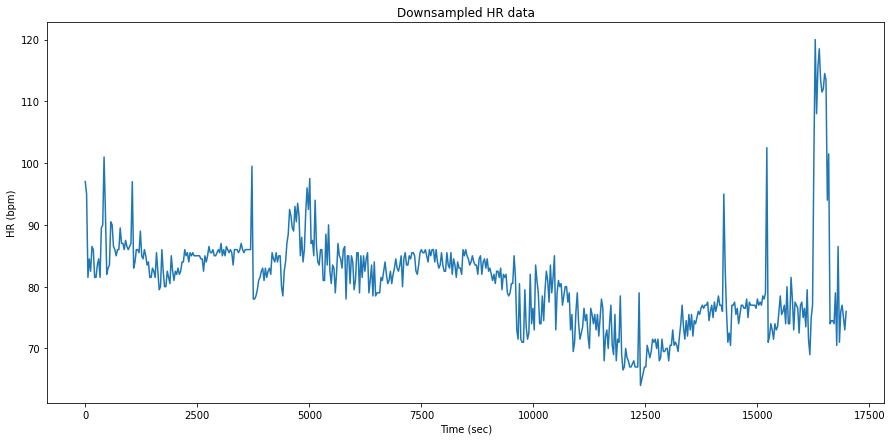

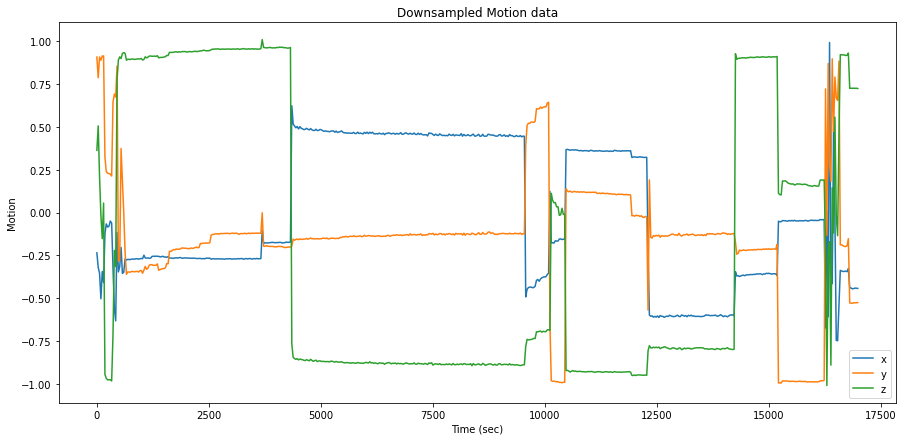

In [18]:
# these functions will allow us to plot our interpolated features

def plot_hr_df(sub_feats, sampfrom=0, sampto=85000):
    plt.figure(figsize=(15,7))
    feature = "hr"

    plt.plot(sub_feats[feature].loc[sampfrom:sampto].index,sub_feats[feature].iloc[sampfrom:sampto,0])
    plt.xlabel("Time (sec)")
    plt.ylabel("HR (bpm)")

    plt.title('Downsampled HR data')
    plt.show()


def plot_motion_df(sub_feats, sampfrom=0, sampto=85000):
    plt.figure(figsize=(15,7))
    feature = "motion"

    plt.plot(sub_feats[feature].loc[sampfrom:sampto].index,sub_feats[feature].iloc[sampfrom:sampto,0], label='x')
    plt.plot(sub_feats[feature].loc[sampfrom:sampto].index,sub_feats[feature].iloc[sampfrom:sampto,1], label='y')
    plt.plot(sub_feats[feature].loc[sampfrom:sampto].index,sub_feats[feature].iloc[sampfrom:sampto,2], label='z')
    plt.legend()
    plt.xlabel("Time (sec)")
    plt.ylabel("Motion")

    plt.title('Downsampled Motion data')
    plt.show()

plot_hr_df(sub_feats)
plot_motion_df(sub_feats)

In [19]:
print(labels.head())
labels.index*30

     0  1
0    0 -1
1   30 -1
2   60 -1
3   90 -1
4  120 -1


RangeIndex(start=0, stop=17010, step=30)

In [20]:
sub_feats["hr"].loc[:510]

,1
0.0,97.0
30.0,95.0
60.0,81.5
90.0,84.5
120.0,82.5
150.0,86.5
180.0,86.0
210.0,81.5
240.0,81.5
270.0,83.5


## Label "4"?

At this stage of the processing and analysis we noticed something odd, there appeared to be some "4"s in the list of sleep status labels. Up to this point we had assumed there were only [0,1,2,3,5] as we had removed the -1 and the study itself suggested the labels are as follows for sleep stages:

**"Each line in this file has the format: date (in seconds since PSG start) stage (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)"**

We decided to remove this from the dataset similar along with the "-1" label, as once again we weren't aware of what it actually meant

The function below, "remove_noise" achieves this

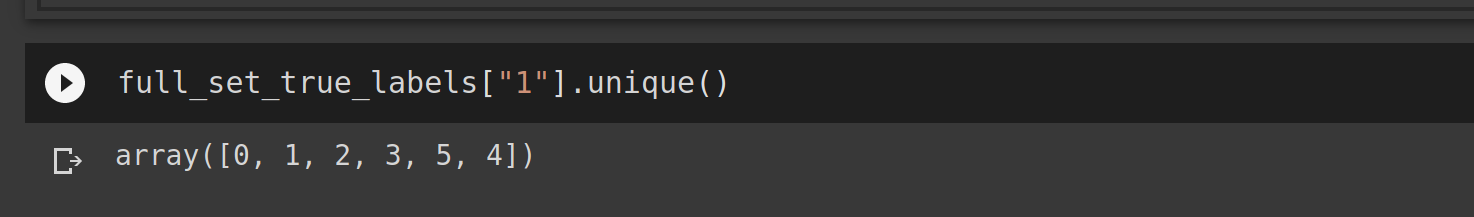

In [21]:
# the times at which label is -1 or 4. We want to remove these time instances from the training data
# because we do not know what class it is

def remove_noise(subject_feats, labels):

    #noise_index = labels.loc[labels[1] == -1].index
    print(labels.columns)
    noise_index = labels.loc[labels[1].isin([-1, 4])].index
    print("noise index:\n", noise_index)

    labels = labels.drop(index=noise_index)
    labels = labels.set_index(0)

    for feature in subject_feats:

      subject_feats[feature] = subject_feats[feature].drop(index=noise_index*30)
    
    return subject_feats, labels

sub_feats, labels = remove_noise(sub_feats, labels)

Int64Index([0, 1], dtype='int64')
noise index:
 Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')


Below we can now see that the entries in out sub_feats from 0 seconds to 360 seconds have been removed as their labels matched either -1 or 4

In [22]:
# our hr feature data after noise index entries were removed for this subject...
sub_feats["hr"].loc[:510]

,1
390.0,90.0
420.0,101.0
450.0,92.0
480.0,82.0
510.0,83.0


And likewise, these same entries in the label data are gone also


In [23]:
# ...and the matching labels
labels.loc[:510]

,1
0,
390,0
420,0
450,0
480,0
510,0


The following print statements show us that all of our times now line up nicely

In [24]:
# now that the times all line up
# we can combine all the features in our dictionary to use as training/testing sets

print(labels.loc[:510], "\n")
print(sub_feats["motion"].loc[:510], "\n")
print(sub_feats["hr"].loc[:510], "\n")

     1
0     
390  0
420  0
450  0
480  0
510  0 

              1         2         3
390.0 -0.559524  0.690460 -0.220322
420.0 -0.631027  0.672783 -0.314140
450.0 -0.115539  0.853889  0.774826
480.0 -0.345749 -0.284614  0.888367
510.0 -0.315613 -0.276604  0.906998 

           1
390.0   90.0
420.0  101.0
450.0   92.0
480.0   82.0
510.0   83.0 



We now needed a function that can iterate through the feature set and join our dataframes together, side by side, leaving a single dataframe containing all feature columns, nicely aligned 

In [25]:
# this function will loop through our feature set and horizontally join the dataframes together
# so our result is one dataframe with all feature columns 

def join_features(subject_features):

    # join the feature dfs horizontally
    joined_feats = pd.DataFrame([])

    for feature in subject_features:
        if feature == "motion":
          subject_features[feature] = subject_features[feature].rename(columns={1:"x",2:"y",3:"z"})
        elif feature == "hr":
          subject_features[feature] = subject_features[feature].rename(columns={1:"hr"})

        joined_feats = pd.concat([joined_feats, subject_features[feature]], axis=1)
    return joined_feats

joined_feats = join_features(sub_feats)
print(joined_feats)

                x         y         z     hr
390.0   -0.559524  0.690460 -0.220322   90.0
420.0   -0.631027  0.672783 -0.314140  101.0
450.0   -0.115539  0.853889  0.774826   92.0
480.0   -0.345749 -0.284614  0.888367   82.0
510.0   -0.315613 -0.276604  0.906998   83.0
...           ...       ...       ...    ...
16860.0 -0.444634 -0.528549  0.723931   76.0
16890.0 -0.442429 -0.525840  0.724411   77.0
16920.0 -0.440208 -0.525605  0.723693   75.0
16950.0 -0.440704 -0.525353  0.724418   73.0
16980.0 -0.441925 -0.524628  0.722458   76.0

[554 rows x 4 columns]


Now that we were happy with the data we could produce for any single subject, we wanted a function that could create this data structure for all of the subjects and join them into two dataframes, one containing time, motion x, motion y, motion z, heartrate; and another with time and the sleep status label. 

In [ ]:
# make training/testing dataset
# this returns a feature array of [time - motion x - motion y - motion z - hr] and an aligned array of labels  [time - label]
# for both the training and test set
# split paramter will create a set of "train" subjects and "test" subjects
# add_id paramter will include the subject id in the resulting dataframe - necessary for tsfresh feature extraction

from sklearn.model_selection import train_test_split

def create_train_test(FULL_SET, feature_set, split=True, test_size=0.2, add_id=False):

    training_set_features = pd.DataFrame([])
    training_set_true_labels = pd.DataFrame([])
    testing_set_features = pd.DataFrame([])
    testing_set_true_labels = pd.DataFrame([])

    if split == False:

        for subject in FULL_SET:

            subject_features, subject_labels = interpolate_features(subject, feature_set)

            subject_features, subject_labels = remove_noise(subject_features, subject_labels)

            joined_features = join_features(subject_features)

            if add_id == True:
                joined_features["id"] = [subject for i in range(0, len(subject_labels))]
                subject_labels["id"] = [subject for i in range(0, len(subject_labels))]

            if np.shape(training_set_features)[0] == 0:
                training_set_features = joined_features
                training_set_true_labels = subject_labels
            else:
                training_set_features = pd.concat((training_set_features, joined_features))
                training_set_true_labels = pd.concat((training_set_true_labels, subject_labels))

        return training_set_features, training_set_true_labels


    training_subjects, testing_subjects = train_test_split(FULL_SET, test_size = test_size)
    print("training set:\n", training_subjects, "\n")
    print("testing set:\n", testing_subjects, "\n")

    # Get labels and features for training and testing sets
    for subject in training_subjects:

        subject_features, subject_labels = interpolate_features(subject, feature_set)

        subject_features, subject_labels = remove_noise(subject_features, subject_labels)

        joined_features = join_features(subject_features)

        if np.shape(training_set_features)[0] == 0:
            training_set_features = joined_features
            training_set_true_labels = subject_labels
        else:
            training_set_features = pd.concat((training_set_features, joined_features))
            training_set_true_labels = pd.concat((training_set_true_labels, subject_labels))

    for subject in testing_subjects:

        subject_features, subject_labels = interpolate_features(subject, feature_set)

        subject_features, subject_labels = remove_noise(subject_features, subject_labels)

        joined_features = join_features(subject_features)

        if np.shape(testing_set_features)[0] == 0:
            testing_set_features = joined_features
            testing_set_true_labels = subject_labels
        else:
            testing_set_features = pd.concat((testing_set_features, joined_features))
            testing_set_true_labels = pd.concat((testing_set_true_labels, subject_labels))

    return training_set_features, training_set_true_labels, testing_set_features, testing_set_true_labels


training_set_features, training_set_true_labels, testing_set_features, testing_set_true_labels = create_train_test(FULL_SET, feature_set, test_size=0.2)

full_set_features, full_set_true_labels = create_train_test(FULL_SET, feature_set, split=False, add_id=True)

full_set_features.to_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_features.csv')
full_set_true_labels.to_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_labels.csv')


Here is a sample of what the above function outputs as it runs, the full output is very long and would take up most of this notebook so we have hidden it:

"length of subject 8258170's labels file: 972

Interpolating motion feature for subject 8258170

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
Interpolating hr feature for subject 8258170

Int64Index([0, 1], dtype='int64')
noise index:
 Int64Index([150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 169,
            175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
            189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202,
            203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
            216, 217, 218, 219, 220, 221, 222, 223, 398, 400, 401, 403, 405,
            408, 409, 410, 411, 418, 419, 420, 421, 422, 423, 424, 425, 426,
            427, 428, 429, 430, 431],
           dtype='int64')"

In [27]:
full_set_true_labels[1].unique()

array([0, 1, 2, 3, 5])

In [28]:
print("Training Set Features", "\n", training_set_features)
print("Training Set Features", "\n", training_set_true_labels)

Training Set Features 
                 x         y         z    hr
0.0     -0.234604  0.643829 -0.713974  65.0
30.0    -0.301849 -0.205375 -0.931488  57.5
60.0    -0.300629 -0.200714 -0.931015  51.5
90.0    -0.296928 -0.199501 -0.934410  50.0
120.0   -0.300675 -0.192085 -0.927177  47.5
...           ...       ...       ...   ...
29340.0 -0.945655  0.049217 -0.322846  66.5
29370.0  0.539521 -0.754646 -0.126137  66.0
29400.0 -0.711884 -0.111618 -0.696038  62.0
29430.0 -0.697182 -0.104553 -0.710816  61.5
29460.0 -0.690986 -0.102600 -0.715798  63.0

[20185 rows x 4 columns]
Training Set Features 
        1
0       
0      0
30     0
60     0
90     0
120    0
...   ..
29340  2
29370  1
29400  1
29430  1
29460  1

[20185 rows x 1 columns]


In [29]:
print("Testing Set Features", "\n", testing_set_features)
print("Testing Set Features", "\n", testing_set_true_labels)

Testing Set Features 
                 x         y         z    hr
240.0   -0.812561 -0.581581  0.023765  77.0
270.0   -0.721108 -0.097038 -0.679436  79.5
300.0    0.415924  0.194603 -0.629395  73.0
330.0   -0.081154  0.423157 -0.895424  73.0
360.0   -0.083824  0.422409 -0.900138  75.0
...           ...       ...       ...   ...
29250.0 -0.109840 -0.955604  0.262016  57.0
29280.0 -0.110085 -0.956581  0.262017  61.0
29310.0 -0.110580 -0.957809  0.262252  63.5
29340.0 -0.112793 -0.955124  0.260727  62.0
29370.0 -0.111054 -0.953903  0.259033  58.0

[6232 rows x 4 columns]
Testing Set Features 
        1
0       
240    0
270    0
300    0
330    0
360    0
...   ..
29250  5
29280  5
29310  5
29340  5
29370  5

[6232 rows x 1 columns]


## Extracting features

In [30]:
!pip install tsfresh

### Prep the dataset for tsfresh package

Typically, the input format options consist of pandas.DataFrame objects. (see [Large Input Data](https://tsfresh.readthedocs.io/en/latest/text/large_data.html#large-data-label) for other input types) There are four important column types that make up those DataFrames.



1.   ***column_id***:

> This column indicates which entities the time series belong to. Features will be extracted individually for each entity (id). The resulting feature matrix will contain one row per id. 


2.   ***column_sort***:

> This column contains values which allow to sort the time series (e.g. time stamps). In general, it is not required to have equidistant time steps or the same time scale for the different ids and/or kinds. 

3. ***column_value***:

> This column contains the actual values of the time series. 



4. ***column_kind***:

> This column indicates the names of the different time series types






In [31]:
# make sure our feature df is all numeric before extracting features
# it should be already but tsfresh was giving errors sometimes

full_set_features2 = full_set_features.reset_index()
full_set_features2 = full_set_features2.rename(columns={"index":"time"})
full_set_features2 = full_set_features2.apply(pd.to_numeric)
print(full_set_features2.head(), "\n")

# Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.

# This function is useful to massage a DataFrame into a format where one or more 
# columns are identifier variables (id_vars), while all other columns, considered 
# measured variables (value_vars), are “unpivoted” to the row axis, 
# leaving just two non-identifier columns, ‘variable’ and ‘value’.

full_set_features2['combine_id'] = list(zip(full_set_features2.id, full_set_features2.time))
full_set_features2 = full_set_features2.drop(columns="id")
melted_features = full_set_features2.melt(id_vars = ["combine_id", "time"])
print(melted_features, "\n")

melted_features.dtypes


    time         x         y         z    hr       id
0  870.0 -0.612717 -0.086441 -0.774131  74.5  8692923
1  900.0 -0.608009 -0.078118 -0.779465  66.5  8692923
2  930.0 -0.608291 -0.074685 -0.776802  68.0  8692923
3  960.0 -0.604043 -0.074944 -0.782837  71.0  8692923
4  990.0 -0.607269 -0.070290 -0.782433  68.0  8692923 

                combine_id     time variable      value
0         (8692923, 870.0)    870.0        x  -0.612717
1         (8692923, 900.0)    900.0        x  -0.608009
2         (8692923, 930.0)    930.0        x  -0.608291
3         (8692923, 960.0)    960.0        x  -0.604043
4         (8692923, 990.0)    990.0        x  -0.607269
...                    ...      ...      ...        ...
105663  (3509524, 12360.0)  12360.0       hr  87.000000
105664  (3509524, 12390.0)  12390.0       hr  87.000000
105665  (3509524, 12420.0)  12420.0       hr  87.000000
105666  (3509524, 12450.0)  12450.0       hr  86.500000
105667  (3509524, 12480.0)  12480.0       hr  87.000000

[

combine_id     object
time          float64
variable       object
value         float64
dtype: object

In [32]:
full_set_true_labels = full_set_true_labels.apply(pd.to_numeric)
#full_set_true_labels2 = full_set_true_labels2.reset_index()
full_set_true_labels.head()

,1,id
0,,
870,0,8692923
900,0,8692923
930,0,8692923
960,0,8692923
990,0,8692923


In [34]:
full_set_true_labels.dtypes

1     int64
id    int64
dtype: object

In [33]:
#new_labels = training_set_true_labels.reset_index(drop=True)
new_labels = pd.Series(full_set_true_labels.loc[:,1])
#new_labels = new_labels.reindex(np.arange(0, len(new_labels) + 1, 30))
new_labels.index = list(zip(full_set_true_labels["id"], full_set_true_labels.index))
print(new_labels.head(), "\n")
new_labels.dtypes

(8692923, 870)    0
(8692923, 900)    0
(8692923, 930)    0
(8692923, 960)    0
(8692923, 990)    0
Name: 1, dtype: int64 



dtype('int64')

In [35]:
from tsfresh import extract_features


# this takes a while ~20mins
X = extract_features(melted_features, column_id="combine_id", column_value="value", column_sort="time")


print(X.shape)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Feature Extraction: 100%|██████████| 5/5 [29:01<00:00, 348.26s/it]


(26417, 779)


In [38]:
# sort our labels on the index of time step, subject id

# our original labels
print(new_labels.head(), "\n")

# create multiIndex by separating id and time
a = pd.MultiIndex.from_tuples(new_labels.index, names=('id', 'time'))

# reindex our labels using this multiIndex
sorted_new_labels = new_labels.reindex(a)


# sort labels according to this new multiIndex
sorted_new_labels.sort_index(inplace=True)

sorted_new_labels.to_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_labels.csv')

sorted_new_labels

(8692923, 870)    0
(8692923, 900)    0
(8692923, 930)    0
(8692923, 960)    0
(8692923, 990)    0
Name: 1, dtype: int64 



id       time 
46343    390      0
         420      0
         450      0
         480      0
         510      0
                 ..
9961348  21450    0
         21480    0
         21510    0
         21540    0
         21570    0
Name: 1, Length: 26417, dtype: int64

In [39]:
# Display Extracted Features for each time step of each subject
print(X)

                 value__variance_larger_than_standard_deviation  ...  value__permutation_entropy__dimension_7__tau_1
46343   390.0                                               1.0  ...                                             NaN
        420.0                                               1.0  ...                                             NaN
        450.0                                               1.0  ...                                             NaN
        480.0                                               1.0  ...                                             NaN
        510.0                                               1.0  ...                                             NaN
...                                                         ...  ...                                             ...
9961348 21450.0                                             1.0  ...                                             NaN
        21480.0                                             1.0 

Drop any features that are NaN / Infinity due to calculations.

In [40]:
X = X.dropna(axis='columns')
# Check shape of feature
X.shape

(26417, 270)

In [41]:
np.where(np.isinf(X))

(array([    0,     1,     2, ..., 26414, 26415, 26416]),
 array([31, 31, 31, ..., 31, 31, 31]))

In [42]:
X = X.drop(X.columns[[31]], axis=1) 

In [43]:
np.where(np.isinf(X))

(array([], dtype=int64), array([], dtype=int64))

In [44]:
# save to csv
X.to_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_2.csv')

In [45]:
import tsfresh
X = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_2.csv')
Y = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_labels.csv')
y_series = pd.Series(Y['1'])



We wanted to see what tsfresh could tell us about some of the more important and significant features it had extracted. So using the relevance function built into tsfresh we created a relevance table and limited it to the top 10 most signficant features. The lower the p_value the more significant the feature. 

In [46]:
tsfresh.feature_selection.relevance.calculate_relevance_table(X, y_series, ml_task='classification').head(10)

,feature,type,p_value,relevant
feature,,,,
Unnamed: 1,Unnamed: 1,real,0.000000e+00,True
value__mean_second_derivative_central,value__mean_second_derivative_central,real,1.931131e-132,True
value__sum_values,value__sum_values,real,1.977369e-123,True
value__mean,value__mean,real,1.977369e-123,True
"value__fft_coefficient__attr_""real""__coeff_0","value__fft_coefficient__attr_""real""__coeff_0",real,1.977407e-123,True
"value__fft_coefficient__attr_""abs""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_0",real,1.977407e-123,True
"value__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)",value__cwt_coefficients__coeff_2__w_20__widths...,real,2.075900e-123,True
"value__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)",value__cwt_coefficients__coeff_2__w_10__widths...,real,2.667607e-123,True
value__absolute_sum_of_changes,value__absolute_sum_of_changes,real,3.061835e-126,True


These features and what they actually mean are far from self explanatory, so we referred to the tsfresh documentation to get some descriptions:

Note that in each of these, if there is a formula shown, "x" is the time series we are extracting the features from  



**Mean second derivative central**


This is the mean value of a central approximation of the second derivative

![2b5ee44fd4bec18894fd0d0ca6527f35c5eae087.png](_images/2b5ee44fd4bec18894fd0d0ca6527f35c5eae087.png)



**Sum values**

Calculates the sum over the time series values



**Mean**

This is simply the mean of the values in the row



**Fft coefficient attr "real"**

Calculates the fourier coefficients of the one-dimensional discrete Fourier Transform for real input by fast fourier transformation algorithm. In this case it returns the real value.

![fft_coeff.png](_images/fft_coeff.png)



**Fft coefficient attr "abs"**

Calculates the fourier coefficients of the one-dimensional discrete Fourier Transform for real input by fast fourier transformation algorithm. In this case it returns the absolute value.

![fft_coeff.png](_images/fft_coeff.png)




**Cwt coefficients w20 widths(2, 5, 10, 20)**

Calculates a Continuous wavelet transform for the Ricker wavelet, also known as the “Mexican hat wavelet” which is defined by

![cwt_coeff.png](_images/cwt_coeff.png)

where a is the width parameter of the wavelet function.

w is 20 in this feature.

This feature calculator takes three different parameter: widths, coeff and w. The feature calculater takes all the different widths arrays and then calculates the cwt one time for each different width array. Then the values for the different coefficient for coeff and width w are returned. (For each dic in param one feature is returned)



**Cwt coefficients w10 widths(2, 5, 10, 20)**

Calculates a Continuous wavelet transform for the Ricker wavelet, also known as the “Mexican hat wavelet” which is defined by

![cwt_coeff.png](_images/cwt_coeff.png)

where a is the width parameter of the wavelet function.

w is 10 in this feature.

This feature calculator takes three different parameter: widths, coeff and w. The feature calculater takes all the different widths arrays and then calculates the cwt one time for each different width array. Then the values for the different coefficient for coeff and width w are returned. (For each dic in param one feature is returned)



**Absolute sum of changes**

Returns the sum over the absolute value of consecutive changes in the series x

![abs_sum.png](_images/abs_sum.png)



**Change quantiles**

First fixes a corridor given by the quantiles ql and qh of the distribution of x. Then calculates the average, absolute value of consecutive changes of the series x inside this corridor.

Think about selecting a corridor on the y-Axis and only calculating the mean of the absolute change of the time series inside this corridor.